In [1]:
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
from datetime import timedelta

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 2*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar
    
# class ResNet18Enc(nn.Module):

#     def __init__(self, num_Blocks=[2,2,2,2], z_dim=128, nc=1):
#         super(ResNet18Enc, self).__init__()
#         self.in_planes = 64
#         self.z_dim = z_dim
#         self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
#         self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
#         self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
#         self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
# #         self.linear = nn.Linear(512, 2 * z_dim)
#         self.linear = nn.Linear(512, z_dim)

#     def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
#         strides = [stride] + [1]*(num_Blocks-1)
#         layers = []
#         for stride in strides:
#             layers += [BasicBlockEnc(self.in_planes, stride)]
#             self.in_planes = planes
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = torch.relu(self.bn1(self.conv1(x)))
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = F.adaptive_avg_pool2d(x, 1)
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
#         mu = x[:, :self.z_dim]
#         logvar = x[:, self.z_dim:]
# #         return mu, logvar
#         return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=128):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )
        
    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [4]:
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 128   # z-size
res_size = 224        # ResNet image size
dropout_p = 0.2
vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim)
vae = nn.DataParallel(vae)
vae = vae.cuda()

In [5]:
list_of_frames = np.load("/media/data_cifs/anagara8/8_video_frame_list.npy")

In [8]:
list_of_frames[0]

'video_2018Y_08M_13D_12h_01m_44s_cam_17202341frame35950.jpg'

In [6]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    pinMem = True # Flag for pinning GPU memory
    print('GPU is available!')
else:
    pinMem = False

GPU is available!


In [10]:
data_dir = '/media/data_cifs/anagara8/video_processed_frames/'
dimension = (224, 224)

# training_data_list = ["frame"+str(frame_idx) for frame_idx in range(4,1000)]
training_data_list = list_of_frames[:256]
img_list = [cv2.imread(data_dir+training_data) for training_data in training_data_list]

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, augmentations = None):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        img = torch.tensor(self.img_list[idx]).float()
        img = torch.permute(img, (2, 0, 1))
        return img

In [12]:
m=len(img_list)

print("Length:",m, "-> Training set size:", int(math.ceil(m-m*0.2)), "| Validation set size:", int(m*0.2))
train_data, val_data = random_split(img_list, [int(math.ceil(m-m*0.2)), int(m*0.2)])

Length: 256 -> Training set size: 205 | Validation set size: 51


In [13]:
batch_size=32
train_set_loader = torch.utils.data.DataLoader(MyDataset(train_data), batch_size=batch_size, num_workers = 4, shuffle=True)
valid_set_loader = torch.utils.data.DataLoader(MyDataset(val_data), batch_size=batch_size, num_workers = 4, shuffle=True)
# test_set_loader = torch.utils.data.DataLoader(MyDataset(test_dataset_list), batch_size=batch_size,shuffle=True, num_workers = 4)
print("Converted to DataLoader")

Converted to DataLoader


In [30]:
# def loss_function(reconstructions, target, mean, logvar):
#     mse_loss = nn.MSELoss()
#     MSE = mse_loss(reconstructions, target)
#     KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
#     return MSE + KLD

def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [31]:
number_of_epochs =  30
learningRate= 0.001

autoencoder_optimizer = optim.Adam(vae.parameters(), lr = learningRate)
scheduler = optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=30, gamma = 0.1)

In [32]:
# os.environ["WANDB_API_KEY"] = "99528c40ebd16fca6632e963a943b99ac8a5f4b7"

# project = "nih_animal_behavior"
# wandb.init(project=project, entity="serrelab", id='Cropped_VAE')

# wandb.config = {
#   "learning_rate": learningRate,
#   "epochs": number_of_epochs,
#   "batch_size": batch_size
# }

[1] Loss -> Training: 410527574.2500000 | Validation: -379775376.0000000
[2] Loss -> Training: -377053703.2500000 | Validation: -23568757.3750000
[3] Loss -> Training: -1262095920.0000000 | Validation: 663967168.0000000
[4] Loss -> Training: -1825981304.0000000 | Validation: 1109420928.0000000
[5] Loss -> Training: -2030837152.0000000 | Validation: 1356910688.0000000
[6] Loss -> Training: -2180688096.0000000 | Validation: 1336562688.0000000
[7] Loss -> Training: -2266351168.0000000 | Validation: 1091541568.0000000
[8] Loss -> Training: -2329891904.0000000 | Validation: 847790624.0000000
[9] Loss -> Training: -2397453856.0000000 | Validation: 636828576.0000000
[10] Loss -> Training: -2444602528.0000000 | Validation: 461131520.0000000
[11] Loss -> Training: -2487211312.0000000 | Validation: 296975112.0000000
[12] Loss -> Training: -2523423072.0000000 | Validation: 117844432.0000000
[13] Loss -> Training: -2561187888.0000000 | Validation: 16519144.0000000
[14] Loss -> Training: -260170811

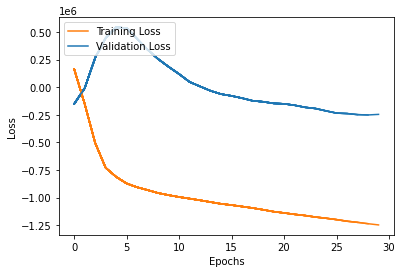

In [33]:
list_train_loss = []
list_val_loss = []

for epoch in range(number_of_epochs):
    train_run_loss = 0 
    val_run_loss = 0
    vae.train(True) # For training
    for image_batch in train_set_loader:
        image_batch = image_batch.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img, z, mean, logvar = vae(image_batch)
        train_loss = loss_function(enc_dec_img, image_batch, mean, logvar)
        # Backward pass
        train_loss.backward()
        autoencoder_optimizer.step()
        train_run_loss += train_loss.data.item()

    vae.eval()
    for image_batch in valid_set_loader:
        image_batch = image_batch.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img, z, mean, logvar = vae(image_batch)
        val_loss = loss_function(enc_dec_img, image_batch, mean, logvar)

        val_run_loss += val_loss.data.item()
        
    print('[%d] Loss -> Training: %.7f | Validation: %.7f' % (epoch + 1, train_run_loss/2, val_run_loss/2))
    list_val_loss.append(val_run_loss/5000)
    list_train_loss.append(train_run_loss/5000)

    plt.plot(range(epoch+1),list_train_loss,'tab:orange',label='Training Loss')
    plt.plot(range(epoch+1),list_val_loss,'tab:blue',label='Validation Loss')
    
#     wandb.log({"train_loss": train_run_loss/5000, "val_loss": val_run_loss/5000})
#     wandb.watch(vae)

    if epoch%1 == 0:
        # Log image(s)
#         plt.imshow(image_batch.squeeze().permute(0, 2, 3, 1).cpu(), cmap='gist_gray')
#         plt.imshow(enc_dec_img.squeeze().detach().cpu(), cmap='gist_gray')        
#         wandb.log({"reconstructed": [wandb.Image(enc_dec_img.squeeze().cpu(), caption="Reconstructed Image")]})
#         wandb.log({"target": [wandb.Image(image_batch.squeeze().cpu(), caption="Target Image")]})
        torch.save(vae.state_dict(), "croppedVAE_e"+str(epoch)+"_vL"+str(val_run_loss)+".p")
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        
    val_run_loss = 0.0
    train_run_loss = 0.0
    
print('Finished Training')

In [37]:
sample_reconstruction = enc_dec_img[0]

TypeError: Invalid shape (3, 224, 224) for image data

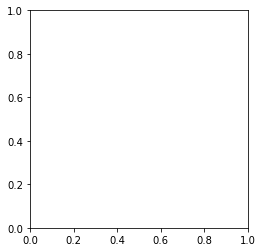

In [45]:
plt.imshow(sample_reconstruction.detach().cpu().transpo)